# BTAlert-AI

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

## Análise dos dados coletados da aplicação

In [2]:
df_all_samples = pd.read_csv('data/samples.csv', delimiter=';', index_col='timestamp')
df_last_samples = df_all_samples.tail(185)
df_all_samples.tail()

,req_failed,request_per_sec,cpu_percent,memory_percent,lock_count,system_health
timestamp,,,,,,
1652274592,0.0559,78.73,0.842445,0.918015,1,0.9441
1652274607,0.0736,82.40,0.825548,0.919022,1,0.9264
1652274622,0.0024,83.20,0.868229,0.919525,1,0.9976
1652274637,0.0436,82.60,0.857559,0.918549,1,0.9564
1652274652,0.0714,76.53,0.854779,0.946320,1,0.9286


## Dicionário de dados

In [3]:
pd.read_csv('data/samples_data_dict.csv', delimiter=';', index_col='column', dtype=str)

,type,range,example,description
column,,,,
timestamp,int64,"[0,+Inf]",1652266207,timestamp when metrics were collected
req_failed,float64,"[0,1]",0.0559,percentage of requests that failed
request_per_sec,float64,"[0,+Inf]",20.93,requests per second sent to the server
cpu_percent,float64,"[0,1]",0.842445,cpu percentage spent
memory_percent,float64,"[0,1]",0.863525,memory percentage spent
lock_count,int64,"[0,+Inf]",2,number of locks in the database
system_health,float64,"[0,1]",0.9286,server's ability to respond to requests correctly


## Matriz de correlação das métricas

<AxesSubplot:>

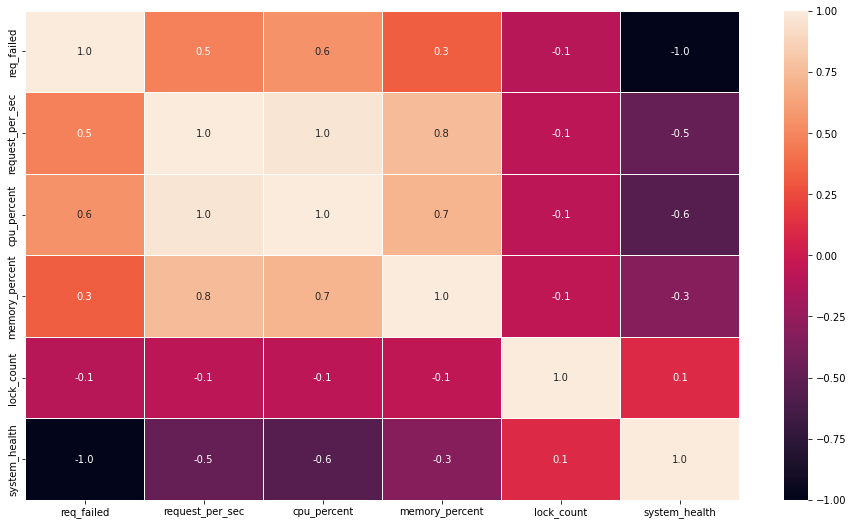

In [4]:
_, ax = plt.subplots(figsize=(16, 9))
sn.heatmap(df_last_samples.corr(), annot=True, fmt='0.1f', linewidths=.6, ax=ax)

A matriz de correlação diz qual a influência que uma métrica tem em cima de outra. Correlações positivas nos diz que quando uma aumenta, a outra tende a aumentar também, e a negativa diz que quando uma diminui, a outra aumenta. Com isso, verificamos que a CPU e a memória RAM possuem uma boa correlação com a saúde do sistema, e por isso foram escolhidas. Já a requesições por segundos está diretamente ligada com a CPU e a memória RAM, e seria redundante, logo, por este motivo não foi escolhida. E por fim, a contagem de lock do banco tem uma correlação muito fraca (mais próximo de 0, mais fraco), e foi deixada de fora do modelo da IA por conta dessa fraca correlação.  
Para o presente trabalho, estamos utilizando apenas os últimos 185 dados, pois há grandes lacunas nas quais o sistema estava indisponível por muito tempo, no qual não foi reiniciado, e isso atrapalharia tanto a correlação, quanto o modelo de IA, por isso a necessidade de filtrar esses dados.

## Análise das métricas de cpu, memória e saúde do sistema

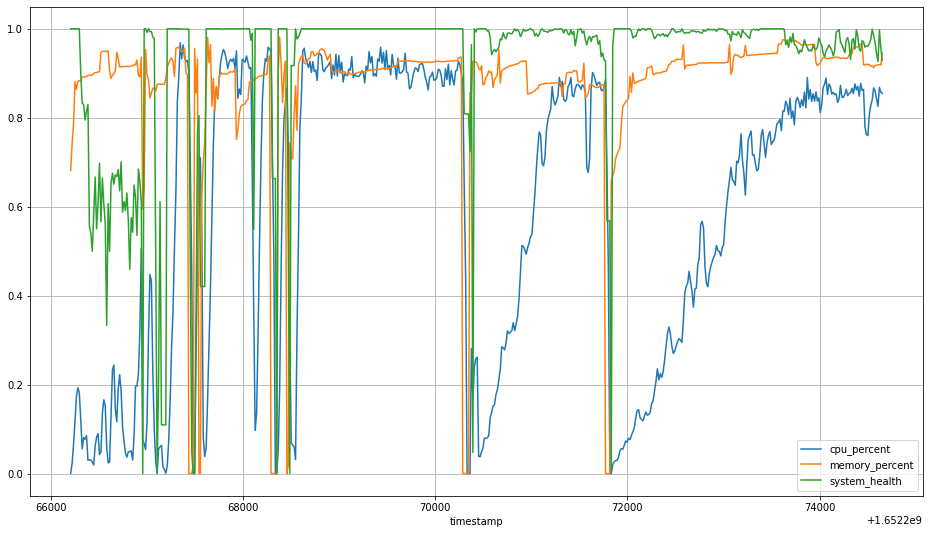

In [5]:
_, ax = plt.subplots(figsize=(16, 9))
df_all_samples.drop(['request_per_sec', 'lock_count', 'req_failed'], axis=1).plot(ax=ax)
ax.grid()
ax.legend()

O gráfico acima mostra o uso de CPU, memória RAM e a saúde do sistema em porcentagem.  
É possível perceber que conforme o uso de memória RAM e CPU aumentam, a saúde do sistema começa a cair, ficando instável. E caso a memória esteja em 0%, a saúde do sistema e o uso de CPU também ficam em 0%, pois é quando o sistema está totalmente indisponível. Notamos que a exaustão do sistema é em torno de 80%+ de uso dos recursos, e caso o sistema fique muito tempo nessa faixa de exaustão, o sistema tende a ficar indisponível após certo período na exaustão.

## Análise das métricas de requisições por segundo, cpu, memória e saúde do sistema momentos antes da aplicação ficar indisponível

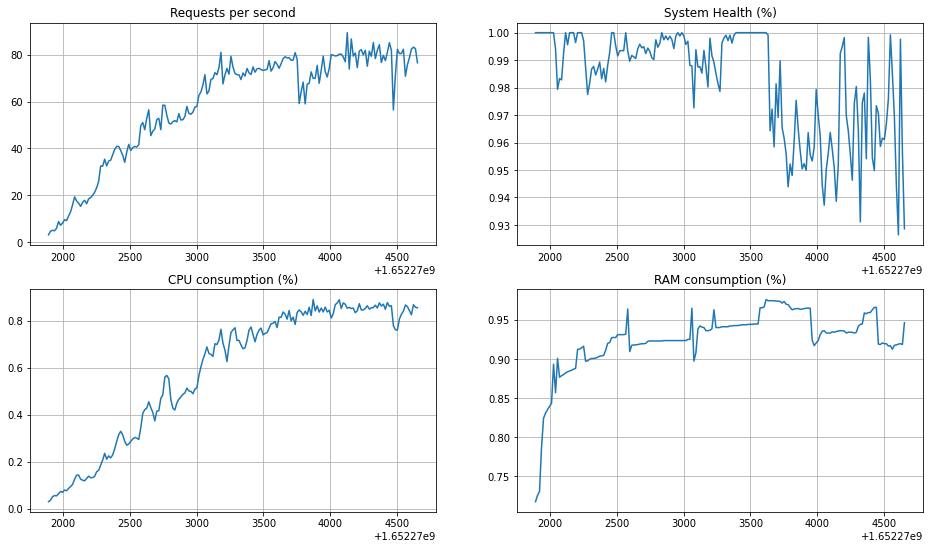

In [6]:
plot_data = (
    (
        ('Requests per second', df_last_samples.request_per_sec),
        ('System Health (%)', df_last_samples.system_health)
    ),
    (
        ('CPU consumption (%)', df_last_samples.cpu_percent),
        ('RAM consumption (%)', df_last_samples.memory_percent)
    )
)

_, ax = plt.subplots(len(plot_data), len(plot_data[0]), figsize=(16, 9))
for i, tup in enumerate(plot_data):
    for j, value in enumerate(tup):
        ax[i][j].set_title(value[0])
        ax[i][j].plot(value[1])
        ax[i][j].grid()

Os gráficos acima mostram a quantidade de requisições por segundo e a saúde do sistema, consumo de CPU e de memória RAM em porcentagem.  
É possível perceber também que, conforme o uso dos recursos aumentam, a saúde do sistema fica instável, uma vez que está chegando na sua faixa de exaustão, que é por volta de 80%+ do uso dos recursos.

# Previsão do System Health com LSTM
A previsão da saúde do sistema está disponível neste colab: https://colab.research.google.com/drive/1vC1BcVlEBRTyoTtMi12sgeoeYKgnsPry?usp=sharing